# Fetch the Dataset

In [94]:
import wandb
import pandas as pd

def parse_count(s: str) -> int:
    s = s.strip().upper()
    if s.endswith("B"):
        return int(float(s[:-1]) * 1_000_000_000)
    elif s.endswith("M"):
        return int(float(s[:-1]) * 1_000_000)
    elif s.endswith("K"):
        return int(float(s[:-1]) * 1_000)
    return int(float(s))

api, data = wandb.Api(), []
frontier = pd.read_csv("https://docs.google.com/spreadsheets/d/1sIr9HRwYbUXKzlskUTMorMa2A_cAzDwE0eUJnk-W1dQ/export?format=csv&gid=1059339506")

for run in api.runs("haok/flame-moe", {"group": {"$regex": "ablation"}}):
    if run.state != "finished": continue
    flops = run.group.split("-").pop()
    loss = run.summary["lm loss validation"]
    num_layers, hidden_size = run.config["num_layers"], run.config["hidden_size"]
    selected = frontier[(frontier["num_layers"] == num_layers) & (frontier["hidden_size"] == hidden_size)]
    active_params, total_params = selected.iloc[0]["active_params"], selected.iloc[0]["total_params"]
    active_params, total_params = parse_count(active_params), parse_count(total_params)
    data.append((flops, active_params, total_params, loss))

df = pd.DataFrame(data, columns=["flops", "active_params", "total_params", "loss"])
display(df)


,flops,active_params,total_params,loss
0,6e18,82200000,239000000,3.365395
1,6e18,219000000,995100000,3.332465
2,3e19,33400000,72600000,3.397310
3,3e19,82200000,239000000,3.135083
4,3e19,37500000,100200000,3.307347
...,...,...,...,...
75,3e18,354900000,1700000000,3.685322
76,3e18,114500000,459400000,3.515386
77,3e18,1500000000,8500000000,6.048109
78,3e18,1000000000,5800000000,5.359854


# Optimize the Coefficients

In [106]:
from math import exp
import warnings

warnings.filterwarnings("ignore")

from tqdm import tqdm
from itertools import product
from scipy.optimize import minimize
import numpy as np


# Step 1: Define the scaling law model
def scaling_law(params, N, D):
    E, A, alpha, B, beta = params
    return E + A / (N**alpha) + B / (D**beta)


# Step 2: Define the loss function
def mse_loss(params, N, D, targets):
    preds = scaling_law(params, N, D)
    return np.mean((preds - targets) ** 2)


def huber_loss(params, N, D, targets, delta=1e-3):
    preds = scaling_law(params, N, D)
    error = np.log(targets) - np.log(preds)
    is_small = np.abs(error) <= delta
    squared = 0.5 * error**2
    linear = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small, squared, linear))


# Step 3: Prepare your data
N = df["active_params"].values
D = (df["flops"].astype(float) / (6 * df["active_params"])).values
targets = df["loss"].values

# Step 4: Set an initial guess
E_range = [exp(-1), exp(-0.5), exp(0), exp(0.5), exp(1.0)]
A_range = [exp(0), exp(5), exp(10), exp(15), exp(20), exp(25)]
alpha_range = [0, 0.5, 1, 1.5, 2]
B_range = [exp(0), exp(5), exp(10), exp(15), exp(20), exp(25)]
beta_range = [0, 0.5, 1, 1.5, 2]
initial_guesses = list(product(E_range, A_range, alpha_range, B_range, beta_range))

# Step 5: Fit using L-BFGS-B
best_result = None
lowest_mse = np.inf

for guess in tqdm(initial_guesses):
    result = minimize(huber_loss, x0=guess, args=(N, D, targets), method="L-BFGS-B")
    if result.success:
        current_mse = huber_loss(result.x, N, D, targets)
        if current_mse < lowest_mse:
            lowest_mse = current_mse
            best_result = result

# Step 6: Show the results
if best_result:
    E_opt, A_opt, alpha_opt, B_opt, beta_opt = best_result.x
    print(f"E     = {E_opt:.6f}")
    print(f"A     = {A_opt:.6f}")
    print(f"alpha = {alpha_opt:.6f}")
    print(f"B     = {B_opt:.6f}")
    print(f"beta  = {beta_opt:.6f}")
    print(f"Loss   = {lowest_mse:.6f}")
else:
    print("Optimization failed for all initial guesses.")


  0%|          | 0/4500 [00:00<?, ?it/s]

100%|██████████| 4500/4500 [00:53<00:00, 84.37it/s] 

E     = 2.241716
A     = 148.413257
alpha = 0.279702
B     = 3269017.372472
beta  = 0.715500
Loss   = 0.000028


# Find the Models

In [20]:
import pandas as pd

def parse_count(s: str) -> int:
    s = s.strip().upper()
    if s.endswith("B"):
        return int(float(s[:-1]) * 1_000_000_000)
    elif s.endswith("M"):
        return int(float(s[:-1]) * 1_000_000)
    elif s.endswith("K"):
        return int(float(s[:-1]) * 1_000)
    return int(float(s))

def scaling_law(N, D):
    # Obtained from MSE 
    # E, A, alpha, B, beta = 2.133594, 65.254366, 0.226854, 485165195.409790, 0.949495
    # Obtained from Huber
    E, A, alpha, B, beta = 2.241716, 148.413257, 0.279702, 3269017.372472, 0.715500
    return E + A / (N**alpha) + B / (D**beta)

# Step 1: Load and transform
df = pd.read_csv("https://docs.google.com/spreadsheets/d/1sIr9HRwYbUXKzlskUTMorMa2A_cAzDwE0eUJnk-W1dQ/export?format=csv&gid=599230821")

# Step 2: Define budgets
budgets = [6e18, 1e19, 3e19, 6e19, 1e20, 3e20, 6e20, 1e21, 3e21, 6e21]
budgets = [2e19, 8e19, 2.4e20, 7.2e20, 9.4e20, 1.2e21, 5.7e21, 1.1e22]

# Step 3: Compute predicted loss and best configs
merged = []
for budget in budgets:
    df["FLOPs"] = budget
    df["tokens"] = budget / (6 * df["active_params"].apply(parse_count))
    df["predicted_loss"] = scaling_law(df["active_params"].apply(parse_count), df["tokens"])
    tops = df.nsmallest(1, "predicted_loss")
    merged.append(tops)

df = pd.concat(merged, ignore_index=True)
df["DCLM scale"] = ["400M-1x", "400M-4x", "1B-1x", "1B-3x", "3B-1x", "1B-5x", "7B-1x", "7B-2x"]
df = df[["DCLM scale", "FLOPs"] + [col for col in df.columns if col != "DCLM scale" and col != "FLOPs"]]
display(df)


,DCLM scale,FLOPs,num_layers,padded_vocab_size,hidden_size,ffn_hidden_size,moe_ffn_hidden_size,num_experts,moe_router_topk,active_params,total_params,tokens,predicted_loss
0,400M-1x,2.000000e+19,12,50304,1024,5472,704,64,8,354.9M,1.7B,9.392317e+09,3.083539
1,400M-4x,8.000000e+19,18,50304,1536,8208,1056,64,8,1.0B,5.8B,1.333333e+10,2.878912
2,1B-1x,2.400000e+20,21,50304,2048,10944,1408,64,8,2.0B,12.0B,2.000000e+10,2.752539
3,1B-3x,7.200000e+20,27,50304,2048,10944,1408,64,8,2.5B,15.5B,4.800000e+10,2.665207
4,3B-1x,9.400000e+20,27,50304,2048,10944,1408,64,8,2.5B,15.5B,6.266667e+10,2.652273
5,1B-5x,1.200000e+21,27,50304,2048,10944,1408,64,8,2.5B,15.5B,8.000000e+10,2.642408
6,7B-1x,5.700000e+21,27,50304,2048,10944,1408,64,8,2.5B,15.5B,3.800000e+11,2.607682
7,7B-2x,1.100000e+22,27,50304,2048,10944,1408,64,8,2.5B,15.5B,7.333333e+11,2.601323


# Plot the Sweep

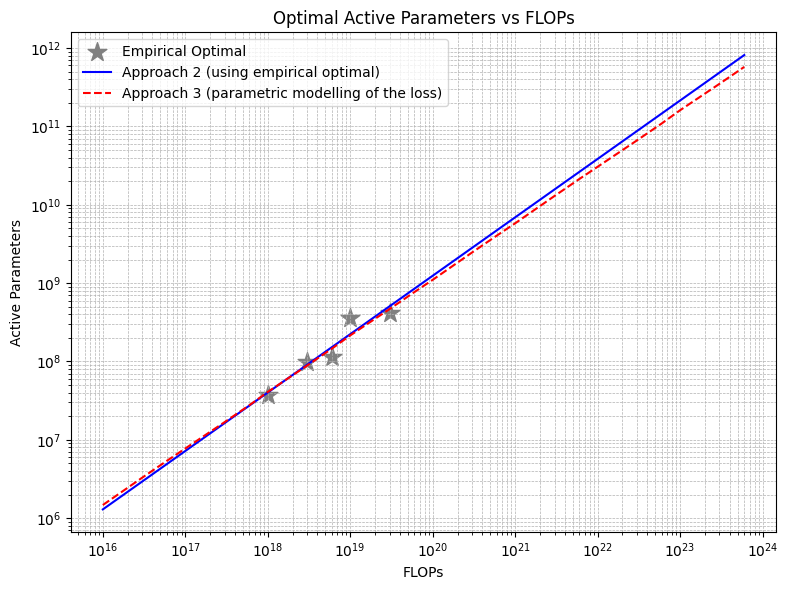

,DCLM scale,DCLM hours,FLOPs,Active Parameters (Approach 2),Active Parameters (Approach 3)
0,400M-1x,26,2.000000e+19,374.2M,354.1M
1,400M-4x,104,8.000000e+19,1.1B,959.3M
2,1B-1x,240,2.400000e+20,2.4B,2.1B
3,1B-3x,720,7.200000e+20,5.4B,4.6B
4,3B-1x,740,9.400000e+20,6.6B,5.5B
5,1B-5x,1200,1.200000e+21,7.9B,6.7B
6,7B-1x,3700,5.700000e+21,25.3B,20.2B
7,7B-2x,7300,1.100000e+22,41.3B,32.3B


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def scaling_law(N, D):
    # Obtained from MSE
    # E, A, alpha, B, beta = 2.133594, 65.254366, 0.226854, 485165195.409790, 0.949495
    # Obtained from Huber
    E, A, alpha, B, beta = 2.241716, 148.413257, 0.279702, 3269017.372472, 0.715500
    return E + A / (N**alpha) + B / (D**beta)


# Define sweep range: 1M to 1T parameters
param_range = np.logspace(6, 12, 500)  # 1M = 10^6, 1T = 10^12

# FLOPs budgets
budgets = []
for exp in range(16, 24):
    for coe in [1, 3, 6]:
        budgets.append(coe * (10**exp))

# Store results
opt_flops = []
opt_params = []

for budget in budgets:
    best_loss = np.inf
    best_param = None

    for N in param_range:
        D = budget / (6 * N)
        loss = scaling_law(N, D)
        if loss < best_loss:
            best_loss = loss
            best_param = N

    opt_flops.append(budget)
    opt_params.append(best_param)

exp_df = df.copy()
# Group by flops and find the row with minimum loss for each flops value
min_loss_idx = exp_df.groupby("flops")["loss"].idxmin()
filtered_df = exp_df.loc[min_loss_idx]
exp_flops = filtered_df["flops"].apply(float).to_numpy()
exp_active_params = filtered_df["active_params"].to_numpy()

# Fit a line to the experimental data
# Convert opt_flops and opt_params to NumPy arrays with appropriate numeric types
opt_flops = np.array(opt_flops, dtype=float)
opt_params = np.array(opt_params, dtype=float)

fit = np.polyfit(np.log10(exp_flops), np.log10(exp_active_params), 1)
fit_line = 10 ** (fit[0] * np.log10(opt_flops) + fit[1])

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(
    exp_flops,
    exp_active_params,
    color="grey",
    label="Empirical Optimal",
    marker="*",
    s=200,
)
plt.plot(
    opt_flops,
    fit_line,
    linestyle="-",
    color="blue",
    label="Approach 2 (using empirical optimal)",
)
plt.plot(
    opt_flops,
    opt_params,
    linestyle="--",
    color="red",
    label="Approach 3 (parametric modelling of the loss)",
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("FLOPs")
plt.ylabel("Active Parameters")
plt.title("Optimal Active Parameters vs FLOPs")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

dclm_budgets = [2e19, 8e19, 2.4e20, 7.2e20, 9.4e20, 1.2e21, 5.7e21, 1.1e22]
dclm_scales = [
    "400M-1x",
    "400M-4x",
    "1B-1x",
    "1B-3x",
    "3B-1x",
    "1B-5x",
    "7B-1x",
    "7B-2x",
]
dclm_hours = [26, 104, 240, 720, 740, 1200, 3700, 7300]
fit_params = 10 ** (fit[0] * np.log10(dclm_budgets) + fit[1])

opt_fit_params = []
for budget in dclm_budgets:
    best_loss = np.inf
    best_param = None
    for N in param_range:
        D = budget / (6 * N)
        loss = scaling_law(N, D)
        if loss < best_loss:
            best_loss = loss
            best_param = N
    opt_fit_params.append(best_param)

dclm_df = pd.DataFrame(
    {
        "DCLM scale": dclm_scales,
        "DCLM hours": dclm_hours,
        "FLOPs": dclm_budgets,
        "Active Parameters (Approach 2)": [f"{n / 1e6:.1f}M" if n < 1e9 else f"{n / 1e9:.1f}B" for n in fit_params],
        "Active Parameters (Approach 3)": [f"{n / 1e6:.1f}M" if n < 1e9 else f"{n / 1e9:.1f}B" for n in opt_fit_params],
    }
)
display(dclm_df)

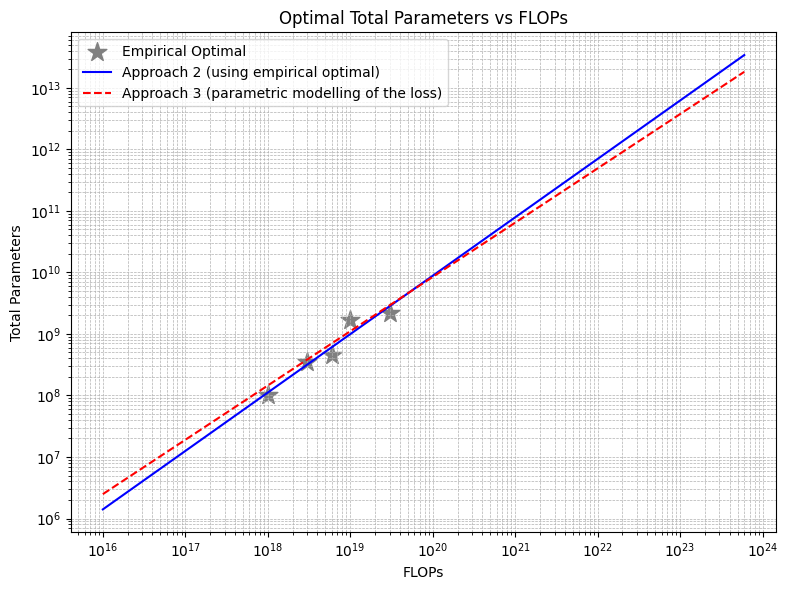

,DCLM scale,DCLM hours,FLOPs,Active Parameters (Approach 2),Active Parameters (Approach 3),Total Parameters (Approach 2),Total Parameters (Approach 3)
0,400M-1x,26,2.000000e+19,374.2M,354.1M,1.9B,2.0B
1,400M-4x,104,8.000000e+19,1.1B,959.3M,7.1B,6.9B
2,1B-1x,240,2.400000e+20,2.4B,2.1B,20.3B,18.3B
3,1B-3x,720,7.200000e+20,5.4B,4.6B,57.5B,48.2B
4,3B-1x,740,9.400000e+20,6.6B,5.5B,74.1B,61.0B
5,1B-5x,1200,1.200000e+21,7.9B,6.7B,93.5B,75.6B
6,7B-1x,3700,5.700000e+21,25.3B,20.2B,410.4B,299.2B
7,7B-2x,7300,1.100000e+22,41.3B,32.3B,766.1B,534.4B


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def scaling_law(N, D):
    # Obtained from Huber
    E, A, alpha, B, beta = 2.369252, 148.413172, 0.271697, 3269017.372472, 0.714774
    return E + A / (N**alpha) + B / (D**beta)


# Define sweep range: 10M to 1B parameters
param_range = np.logspace(7, 9, 20)  # 1M = 10^6, 1B = 10^9

# FLOPs budgets
budgets = []
for exp in range(16, 24):
    for coe in [1, 3, 6]:
        budgets.append(coe * (10**exp))
budgets = np.array(budgets, dtype=float)

exp_df = df.copy()
# Group by flops and find the row with minimum loss for each flops value
min_loss_idx = exp_df.groupby("flops")["loss"].idxmin()
filtered_df = exp_df.loc[min_loss_idx]
exp_flops = filtered_df["flops"].apply(float).to_numpy()
exp_total_params = filtered_df["total_params"].to_numpy()
exp_active_params = filtered_df["active_params"].to_numpy()
fit = np.polyfit(np.log10(exp_flops), np.log10(exp_total_params), 1)
fit_line = 10 ** (fit[0] * np.log10(budgets) + fit[1])

opt_flops = []
opt_total_params = []
for budget in [1e18, 3e18]:
    best_loss = np.inf
    best_param = None

    for N in param_range:
        D = budget / (6 * N)
        loss = scaling_law(N * 5.5, D)
        if loss < best_loss:
            best_loss = loss
            best_param = N * 5.5

    opt_flops.append(budget)
    opt_total_params.append(best_param)
opt_fit = np.polyfit(np.log10(opt_flops), np.log10(opt_total_params), 1)
opt_fit_line = 10 ** (opt_fit[0] * np.log10(budgets) + opt_fit[1])

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(
    exp_flops,
    exp_total_params,
    color="grey",
    label="Empirical Optimal",
    marker="*",
    s=200,
)
plt.plot(
    budgets,
    fit_line,
    linestyle="-",
    color="blue",
    label="Approach 2 (using empirical optimal)",
)
plt.plot(
    budgets,
    opt_fit_line,
    linestyle="--",
    color="red",
    label="Approach 3 (parametric modelling of the loss)",
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("FLOPs")
plt.ylabel("Total Parameters")
plt.title("Optimal Total Parameters vs FLOPs")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

dclm_budgets = [2e19, 8e19, 2.4e20, 7.2e20, 9.4e20, 1.2e21, 5.7e21, 1.1e22]
fit_params = 10 ** (fit[0] * np.log10(dclm_budgets) + fit[1])
opt_fit_params = 10 ** (opt_fit[0] * np.log10(dclm_budgets) + opt_fit[1])
dclm_df["Total Parameters (Approach 2)"] = [f"{n / 1e6:.1f}M" if n < 1e9 else f"{n / 1e9:.1f}B" for n in fit_params]
dclm_df["Total Parameters (Approach 3)"] = [f"{n / 1e6:.1f}M" if n < 1e9 else f"{n / 1e9:.1f}B" for n in opt_fit_params]
display(dclm_df)